<a href="https://colab.research.google.com/github/Dharmin-Shah/PokemonImageClassifier/blob/main/Pokemon_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Pokemon Image Classifier </b>
---




## <b>Introduction </b>

As an application of CNN, I will be creating an application that can identify the Pokemon based on the image provided.

For this we are using Tensorflow and Kaggle's Pokemon dataset.

> Let's start with imports

In [2]:
import os
import random
import shutil
import joblib
from google.colab import files

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from tensorflow.keras.preprocessing import image
from PIL import Image
import urllib.request

## Fetching Pokemon Image Data

> Before this function is called, it is important to refer to the following link [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials) to get the kaggle.json file. Once the file has been downloaded, the process can continue.

In [6]:
def kaggle_dataset_fetch(kgdata):
  '''
  This function will dowanload and unzip the required dataset.
  Initial lines of code are necessary to install the kaggle api and use the
  kaggle.json file to link the dataset.

  ARGS: Kaggle dataset name that needs to be downloaded. This can be obtained by 
         using the 'Copy API Command' from dataset's page. The last argument in the
         command is the dataset name.
  '''

  #Installing kaggle api
  os.system("pip install -q kaggle")

  # Remove any exiting kaggle.json file
  #os.system("rm -f kaggle.json")
  
  # Cleanup
  os.system("rm -r -f ~/.kaggle/")
  os.system("mkdir ~/.kaggle/")
  
  # Uploading the kaggle.json file
  uploaded = files.upload()
  
  if uploaded.get("kaggle.json") == None:
    raise Exception("kaggle.json was not found. Please upload again")
  
  # Granting permissions
  os.system("cp kaggle.json ~/.kaggle/")
  os.system("chmod 600 /root/.kaggle/kaggle.json")

  #Download voice dataset for testing
  print(f"kaggle datasets download -d {kgdata}")
  os.system(f"kaggle datasets download -d {kgdata}")

  #Unzipping the dataset
  z = os.popen("ls *.zip").read()
  os.system(f"unzip {z}")
  
  #Removing zip file once we unzip it
  os.system(f"rm -f {z}")

In [7]:
kaggle_dataset_fetch("lantian773030/pokemonclassification")

Saving kaggle.json to kaggle.json
kaggle datasets download -d lantian773030/pokemonclassification


## Data Preparation

> We will be splitting the data into train and test data. The following function will create a directory structure for the same.

In [8]:
def prepare_train_test(data,ma_dir,tr_dir,test=0.3):
  
  '''
  This function will prepare the train, test folders and copy the data required for
  our experiment.

  ARGS:
    - data:   The data for which the train,test data needs to be prepared
    - ma_dir: The unzipped dataset that has all the data
    - tr_dir: The target directory under which the train and test folder need to be
              created.
    - test:   The size of test data to be generated per folder
  '''


  # Creating the directory for the train and test data and copying subdirectories to train data
  for i in data:
    # Copy the images with structure
    shutil.copytree(f"{ma_dir}/{i}",f"{tr_dir}/train_data/{i}")
    # Copy the structure for test data
    shutil.copytree(f"{ma_dir}/{i}",f"{tr_dir}/test_data/{i}",ignore=shutil.ignore_patterns('*.*'))
  
  # Randomly choosing files from train data to move them to test data
  for pokemon in os.listdir(f"{tr_dir}/train_data/"):
    pop = os.listdir(f"{tr_dir}/train_data/{pokemon}")
    test_size = len(pop) * test
    random.shuffle(pop)
    test_data = pop[-int(test_size):]
    
    # Moving the test data to test folder
    for f in test_data:
      shutil.move(f"{tr_dir}/train_data/{pokemon}/{f}",f"{tr_dir}/test_data/{pokemon}")

In [9]:
data = os.listdir("PokemonData")
ma_dir = "PokemonData"
tr_dir = "PokeData"

In [10]:
prepare_train_test(data,ma_dir,tr_dir)

In [11]:
train_path = f"{tr_dir}/train_data"
test_path = f"{tr_dir}/test_data"

## Image Pre-Processing

> In this section will apply some transformations on the images so our model doesn't overfit. These transformations include rotation, flip and etc.

In [12]:
# Creating an image genertaor to apply random transformation on the images
image_gen = ImageDataGenerator(rotation_range=20,
                               rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

> Testing out one of the images

In [13]:
# Copy path of any image from train dataset
img_path = "PokeData/train_data/Arbok/2382e5e913f94dd7845e6b1ac733ef18.jpg"

In [14]:
# Image shape = Height x Width x Channel(R,G,B)
imread(img_path).shape

(199, 199, 3)

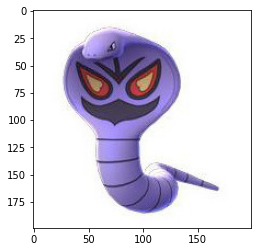

In [15]:
# Image before the transformation
plt.imshow(imread(img_path))

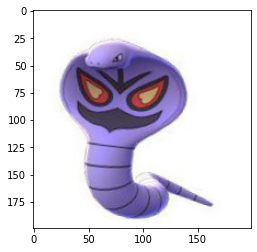

In [16]:
# Image after a random transformation
plt.imshow(image_gen.random_transform(imread(img_path)))

> Now we provide the train and test directories to the image generator which will apply the random transformations and send it to model

In [17]:
image_gen.flow_from_directory(train_path)

Found 4844 images belonging to 150 classes.


In [18]:
image_gen.flow_from_directory(test_path)

Found 1976 images belonging to 150 classes.


## Creating and training model

> We will now create the model with the Convultional and Max Pooling Layers.

In [19]:
# Setting the inupt image size
image_shape = (256,256,3)

> Creating the model

In [20]:
# Creating a CNN model with 5 layers 64,128,128,128 and 256 filters each with 3x3 kernel size and pooling layers with size 2
# Adding 3 dense layers with 1024,512 neurons with final layer with 150 outputs.
# Batch Normalization and Dropout layers

model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))

model.add(Dropout(rate=0.25))

model.add(Dense(512,activation='relu'))

model.add(Dense(150,activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       2

> Choose a batch size. Usually should be 2<sup>n</sup> where n = 4,5,6,7,8

In [22]:
# Choosing the batch size
batch_size = 16

> We now define the generators for our training and validation. The image generator we created earlier will be used to get the images for both.
> This will allow the augmented images to be present or training and validation

In [23]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 4844 images belonging to 150 classes.


In [24]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1976 images belonging to 150 classes.


> Training the model. As this is a large network, it will take considerable amount of time

In [25]:
# Training the model
results = model.fit(train_image_gen,epochs=80,validation_data=test_image_gen)

Epoch 1/80
303/303 [==============================] - 151s 388ms/step - loss: 8.0304 - accuracy: 0.0091 - val_loss: 4.9041 - val_accuracy: 0.0152
Epoch 2/80
303/303 [==============================] - 115s 381ms/step - loss: 4.7065 - accuracy: 0.0188 - val_loss: 4.6353 - val_accuracy: 0.0314
Epoch 3/80
303/303 [==============================] - 115s 381ms/step - loss: 4.3737 - accuracy: 0.0403 - val_loss: 4.7690 - val_accuracy: 0.0294
Epoch 4/80
303/303 [==============================] - 115s 379ms/step - loss: 4.0926 - accuracy: 0.0642 - val_loss: 5.0438 - val_accuracy: 0.0339
Epoch 5/80
303/303 [==============================] - 115s 379ms/step - loss: 3.8672 - accuracy: 0.0948 - val_loss: 3.6797 - val_accuracy: 0.1280
Epoch 6/80
303/303 [==============================] - 115s 379ms/step - loss: 3.5972 - accuracy: 0.1420 - val_loss: 3.4021 - val_accuracy: 0.1538
Epoch 7/80
303/303 [==============================] - 115s 378ms/step - loss: 3.3416 - accuracy: 0.1744 - val_loss: 3.7536 -

### Saving model

> We can save the model to a pickle file and load it later whenever we want.

Caution: Once the model is saved, we need to download it, as the server data is refreshed when the runtime is refeshed.

In [26]:
model.save('PokemonCNN.h5')

## Evaluating the model

> We can evaluate the performance of the model and observe the loss.

In [39]:
model.evaluate(test_image_gen)

124/124 [==============================] - 32s 259ms/step - loss: 2.3340 - accuracy: 0.5840


[2.334026575088501, 0.5840080976486206]

### Testing the model on new image

> We can now let the model predict the pokemon for unseen images.

In [50]:
def predict_pokemon(img_url):

  '''
  This function will take the image url and return the predicted pokemon.
  '''

  # Fetching Image URL 
  url = img_url
  test_image_path = urllib.request.urlopen(url)
  
  # Using Image lib to resize image
  img = Image.open(test_image_path)
  img = img.resize((256,256))
  
  plt.imshow(img)
  plt.show()
  
  # Dropping the transperency channel if it exists
  
  img = np.array(img)
  if img.shape[2] != 3:
      img = img[:,:,:3]
  
  # Converting to array, normalizing and expanding the dims (input shape for model is [batch_num,height,width,channel])
  
  img = img/255
  my_img_array = np.expand_dims(img,axis=0)

  # Fething the prediction
  pred_class = np.argmax(model.predict(my_img_array),axis=-1)
  
  poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
  print(poke_class[pred_class[0]])

> A list of image urls for different pokemons.

In [51]:
img = 'http://www.pngmart.com/files/12/Pokemon-Charizard-PNG-Image.png'
img2 = 'https://www.pngkey.com/png/full/149-1492440_pokemon-jigglypuff-png-jigglypuff-pokemon.png'
img3 = 'https://smallimg.pngkey.com/png/small/62-623293_pokemon-conquest-pokemon-art.png'
img4 = 'https://smallimg.pngkey.com/png/small/1-16272_pokemon-logo-png-transparent-pokemon-vector.png'
img5 = 'https://www.pngkey.com/png/full/62-622689_fire-pokemon-png-moltres-pokemon.png'
img6 = 'https://www.pngkey.com/png/full/66-668441_jpg-library-library-redo-ultimate-mewtwo-by-pokemon.png'

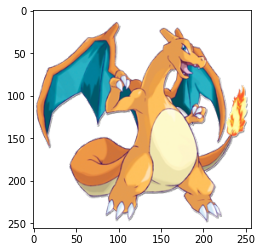

Charizard


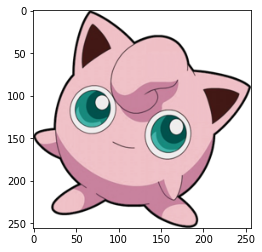

Jigglypuff


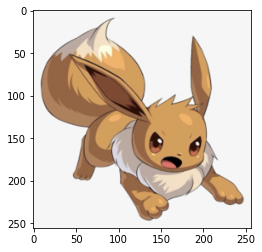

Eevee


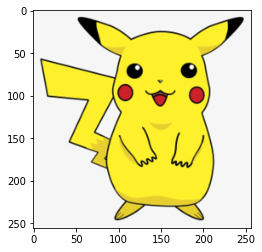

Pikachu


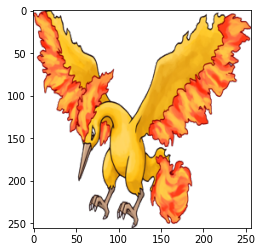

Moltres


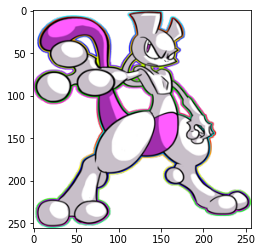

Mewtwo


In [52]:
pokemon = [img,img2,img3,img4,img5,img6]

for i in pokemon:
  predict_pokemon(i)